**<font color = black size=6>实验十二：神经网络</font>**

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Function
import os  

本实验使用Pytorch框架搭建神经网络，其他类似的框架还有TensorFlow。若同学对TensorFlow框架更为熟悉，可使用TensorFlow完成本次实验

**<font color = blue size=4>第一部分:PyTorch介绍</font>**

这里介绍一小部分PyTorch常用的库和函数，更多需求可参阅[PyTorch官方教程](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)以及[PyTorch官方文档](https://pytorch.org/docs/stable/index.html)。

In [22]:
 print(torch.__version__) # 输出当前版本

1.12.1


**<font color = green size=3>1.Tensor</font>**

Tensor与NumPy中的ndarray很相似，但Tensor可以利用GPU来加速计算（本次实验中暂不涉及这部分内容）。

1.1. Tensor的创建

In [23]:
# 创建一个未初始化的Tensor
x = torch.empty(2, 3)
print(x)

# 从一个列表创建Tensor
x = torch.tensor([[1,2,3],[4,5,6]])
print(x)

# 创建一个随机Tensor
x = torch.rand([3, 4])
print(x)

# 创建一个全零Tensor
x = torch.zeros([2, 3])
print(x)

# 创建一个全一Tensor
x = torch.ones([2, 3])
print(x)

tensor([[6.3058e-44, 6.8664e-44, 7.0065e-44],
        [6.3058e-44, 6.7262e-44, 7.1466e-44]])
tensor([[1, 2, 3],
        [4, 5, 6]])
tensor([[0.7576, 0.2793, 0.4031, 0.7347],
        [0.0293, 0.7999, 0.3971, 0.7544],
        [0.5695, 0.4388, 0.6387, 0.5247]])
tensor([[0., 0., 0.],
        [0., 0., 0.]])
tensor([[1., 1., 1.],
        [1., 1., 1.]])


1.2. Tensor的运算

In [24]:
# 加减法
x = torch.tensor([[1,2,3],
                  [4,5,6]])
y = torch.tensor([[6,5,4],
                  [3,2,1]])
print(x + y)
print(x - y)

# 对应位置相乘
print(x * y)
print(x.mul(y))

# 矩阵乘法
print(x.matmul(y.T))
print(x @ y.T)

# reshape
print(x.reshape(3, 2))

# 拼接
print(torch.cat([x,y], dim=0)) # 纵向拼接
print(torch.cat([x,y], dim=1)) # 横向拼接

tensor([[7, 7, 7],
        [7, 7, 7]])
tensor([[-5, -3, -1],
        [ 1,  3,  5]])
tensor([[ 6, 10, 12],
        [12, 10,  6]])
tensor([[ 6, 10, 12],
        [12, 10,  6]])
tensor([[28, 10],
        [73, 28]])
tensor([[28, 10],
        [73, 28]])
tensor([[1, 2],
        [3, 4],
        [5, 6]])
tensor([[1, 2, 3],
        [4, 5, 6],
        [6, 5, 4],
        [3, 2, 1]])
tensor([[1, 2, 3, 6, 5, 4],
        [4, 5, 6, 3, 2, 1]])


1.3. Tensor与ndarray的相互转换

In [25]:
x = torch.tensor([[1,2,3],[4,5,6]])
print(x)

# 从Tensor转换到ndarray
y = x.numpy()
print(y)

# Tensor与ndarray是共享空间的
x[:]=0
print(y)

# 从ndarray到Tensor
z = torch.from_numpy(y)
print(z)

tensor([[1, 2, 3],
        [4, 5, 6]])
[[1 2 3]
 [4 5 6]]
[[0 0 0]
 [0 0 0]]
tensor([[0, 0, 0],
        [0, 0, 0]])


**<font color = green size=3>2.梯度计算</font>**

2.1 梯度计算

In [26]:
#定义变量
a = torch.tensor([[1., 2.]], requires_grad=True)
b = torch.tensor([[3.], [4.]])
c = torch.tensor(5., requires_grad=True)

#计算输出
z = a @ b + c

#自动计算梯度
z.backward()

#输出叶子节点的梯度
print(a.grad) #z对a的梯度
print(b.grad) #由于b默认requires_grad为false，因此无法计算梯度，输出为None
print(c.grad) #z对c的梯度

tensor([[3., 4.]])
None
tensor(1.)


2.2 梯度清零

In [27]:
#支持多种运算求梯度，如torch.mean(),torch.sum()等
a = torch.ones(20, requires_grad=True)
z = torch.sum(torch.sigmoid(a))
z.backward()
print("梯度（a.grad）:", a.grad)


#多次求梯度时梯度会累加，可使用tensor.grad.zero_()进行手动清零
x = torch.tensor(2., requires_grad=True)
y = x ** 2
y.backward()
print("求梯度后的结果（x.grad）:", x.grad)

z = x + 3
# x.grad.zero_()  #可以将这句进行手动清零的代码注释掉后查看输出结果，来看到梯度清零的作用
z.backward()
print("求梯度后的结果（x.grad）:", x.grad)


梯度（a.grad）: tensor([0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966,
        0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966,
        0.1966, 0.1966])
求梯度后的结果（x.grad）: tensor(4.)
求梯度后的结果（x.grad）: tensor(5.)


**<font color = green size=3>3. 神经网络</font>**

3.1 神经网络的构建

In [28]:
# 定义神经网络模型，继承自nn.Module
class Net(nn.Module):
    #输入层的维度为 input_dim
    #隐藏层的维度为 hidden_dim
    #输出层的维度为 output_dim
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        #激活函数relu，用于在全连接层之间加入非线性变换
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out1 = self.relu(out)
        out2 = self.fc2(out1)
        return out1,out2


# 创建神经网络模型实例并输出
net = Net(10,5,1)
print(net)

Net(
  (fc1): Linear(in_features=10, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=1, bias=True)
  (relu): ReLU()
)


3.2 神经网络参数查询

In [29]:
# 该神经网络中可学习的参数可以通过net.parameters()访问
params = list(net.parameters())
print([params[i].size() for i in range(len(params))])  
print("Parameters:",params)

[torch.Size([5, 10]), torch.Size([5]), torch.Size([1, 5]), torch.Size([1])]
Parameters: [Parameter containing:
tensor([[ 0.1155, -0.1232, -0.0231, -0.0285,  0.0458, -0.0013,  0.2764,  0.0984,
         -0.1178, -0.1910],
        [-0.0530, -0.1364, -0.1013,  0.0151,  0.1885,  0.1719, -0.3091,  0.1960,
          0.0883,  0.3000],
        [ 0.2087, -0.2881, -0.3007, -0.1525,  0.2777, -0.0527,  0.1353, -0.1470,
          0.3103, -0.1338],
        [ 0.2371,  0.0037, -0.1666,  0.1625, -0.1679,  0.0930, -0.0913, -0.0347,
         -0.3040, -0.1508],
        [ 0.1716, -0.0769,  0.3150,  0.2535, -0.0148, -0.2111,  0.1926,  0.0981,
         -0.2044,  0.2054]], requires_grad=True), Parameter containing:
tensor([ 0.1920,  0.2805, -0.1773, -0.0521, -0.0061], requires_grad=True), Parameter containing:
tensor([[ 0.0653, -0.3394, -0.3174,  0.2433, -0.1049]], requires_grad=True), Parameter containing:
tensor([0.2185], requires_grad=True)]


3.3 神经网络前向传播

In [30]:
net.eval()
#输入维度为10，生成数据
input=torch.ones([1,10])
input=input.float()

# 进行一次forward()前向传播
output1, output2  = net(input) 

# 前向传播并输出每一层的输出值
print("Output of first layer:", output1)
print("Output of second layer:", output2)

Output of first layer: tensor([[0.2434, 0.6405, 0.0000, 0.0000, 0.7229]], grad_fn=<ReluBackward0>)
Output of second layer: tensor([[-0.0588]], grad_fn=<AddmmBackward0>)


3.4 神经网络反向传播

In [31]:
loss_fn = nn.MSELoss()
target = torch.randn(1, 1)
loss = loss_fn(output2, target)

# 反向传播并输出每一层的梯度
net.zero_grad()
loss.backward()

print("Gradients of first layer:")
print(net.fc1.weight.grad)
print(net.fc1.bias.grad)

print("Gradients of second layer:")
print(net.fc2.weight.grad)
print(net.fc2.bias.grad)

Gradients of first layer:
tensor([[-0.0447, -0.0447, -0.0447, -0.0447, -0.0447, -0.0447, -0.0447, -0.0447,
         -0.0447, -0.0447],
        [ 0.2320,  0.2320,  0.2320,  0.2320,  0.2320,  0.2320,  0.2320,  0.2320,
          0.2320,  0.2320],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0717,  0.0717,  0.0717,  0.0717,  0.0717,  0.0717,  0.0717,  0.0717,
          0.0717,  0.0717]])
tensor([-0.0447,  0.2320,  0.0000,  0.0000,  0.0717])
Gradients of second layer:
tensor([[-0.1664, -0.4378,  0.0000,  0.0000, -0.4942]])
tensor([-0.6836])


3.5 训练神经网络的全过程例子

In [32]:
# 创建一个简单的线性回归模型
model = nn.Linear(1, 1)
print(list(model.parameters()))
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

Epoch=10

#生成数据
inputs = torch.tensor([[1.0], [2.0], [3.0]])
labels = torch.tensor([[2.0], [4.0], [6.0]])

# 模拟训练过程
for epoch in range(Epoch):
    # 模拟输入数据和标签
    
    # 前向传播
    outputs = model(inputs)

    # 计算损失
    loss = criterion(outputs, labels)
    
    #梯度清零
    optimizer.zero_grad()
    
    
    # 反向传播
    loss.backward()

    
    # 更新参数
    optimizer.step()

    # 打印梯度值
    print('Epoch [{}/{}], Loss: {}'.format(epoch+1,Epoch, loss),'. Gradient: {}'.format(model.weight.grad))
    #print('Gradient: {}'.format(model.weight.grad))


[Parameter containing:
tensor([[0.4957]], requires_grad=True), Parameter containing:
tensor([-0.9261], requires_grad=True)]
Epoch [1/10], Loss: 16.990381240844727 . Gradient: tensor([[-17.7445]])
Epoch [2/10], Loss: 13.431427955627441 . Gradient: tensor([[-15.7736]])
Epoch [3/10], Loss: 10.618260383605957 . Gradient: tensor([[-14.0213]])
Epoch [4/10], Loss: 8.394593238830566 . Gradient: tensor([[-12.4634]])
Epoch [5/10], Loss: 6.636898040771484 . Gradient: tensor([[-11.0783]])
Epoch [6/10], Loss: 5.247527122497559 . Gradient: tensor([[-9.8469]])
Epoch [7/10], Loss: 4.149295806884766 . Gradient: tensor([[-8.7520]])
Epoch [8/10], Loss: 3.2811965942382812 . Gradient: tensor([[-7.7787]])
Epoch [9/10], Loss: 2.595003843307495 . Gradient: tensor([[-6.9133]])
Epoch [10/10], Loss: 2.052598714828491 . Gradient: tensor([[-6.1439]])


3.5 神经网络参数更新

1) 用梯度下降法(手动)更新net中的参数

In [33]:
#for f in net.parameters():
    #f.data.sub_(f.grad.data * learning_rate)

2) 用PyTorch的优化器来更新net中的参数

In [34]:
#选择优化器
#optimizer = optim.SGD(net.parameters(), lr=0.01)

# 建立循环:
#optimizer.zero_grad()             # 梯度清零
#output = net(input)               # 前向传播
#loss = criterion(output, target)  # 计算误差
#loss.backward()                   # 后向传播
#optimizer.step()                  # 参数更新

**<font color = blue size=4>第二部分:实验内容</font>**

[Red Wine Quality](https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009)是一个关于红酒品质的数据集，总共有1599个样本，每个样本包含11个(都是连续的)特征以及1个标签，每个标签的取值是连续的。本次实验已经按照8：2的比例划分成了训练数据集'wine_train.csv'以及测试数据集'wine_test.csv'，且每个数据集都已经做了归一化处理。

<span style="color:purple">1) 读入训练数据集'wine_train.csv'与测试数据集'wine_test.csv'。</span>

In [35]:
# your code here

# 读入训练集 并转换为tensor
train = pd.read_csv("wine_train.csv")
train = np.array(train)
train = torch.tensor(train, requires_grad=True, dtype=torch.float)
# 读入测试集 并转换为tensor
test = pd.read_csv("wine_test.csv")
test = np.array(test)
test = torch.tensor(test, requires_grad=True, dtype=torch.float)

<span style="color:purple">2) 利用线性层和激活函数搭建一个神经网络，要求输入和输出维度与数据集维度一致，而神经网络深度、隐藏层大小、激活函数种类等超参数自行调整。</span>

In [36]:
# your code here


# 输入层的维度为 input_dim
# 隐藏层的维度为 hidden_dim
# 输出层的维度为 output_dim
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim):
        super(Net, self).__init__()
        # 线性层
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.fc4 = nn.Linear(hidden_dim3, output_dim)
        # 激活函数relu
        self.relu = nn.ReLU()
        # 激活函数sigmoid
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out1 = self.relu(self.fc1(x))  # relu激活函数
        out2 = self.relu(self.fc2(out1))  # relu激活函数
        out3 = self.fc3(out2)  # 无激活函数
        out4 = self.fc4(out3)  # 无激活函数
        return out4


# 输入和输出的维度设置为数据集维度
in_features_d = train.shape[1] - 1
out_features_d = 1
print(in_features_d)
print(out_features_d)

# 设置随机数种子
seed = 1
torch.manual_seed(seed)

net = Net(in_features_d, 5, 10, 3, out_features_d)
print(net)

# 该神经网络中可学习的参数可以通过net.parameters()访问
params = list(net.parameters())
print([params[i].size() for i in range(len(params))])
print("Parameters:", params)

11
1
Net(
  (fc1): Linear(in_features=11, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=3, bias=True)
  (fc4): Linear(in_features=3, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)
[torch.Size([5, 11]), torch.Size([5]), torch.Size([10, 5]), torch.Size([10]), torch.Size([3, 10]), torch.Size([3]), torch.Size([1, 3]), torch.Size([1])]
Parameters: [Parameter containing:
tensor([[ 0.1554, -0.1331, -0.0585,  0.1415, -0.2839,  0.1808, -0.0620,  0.1534,
          0.0419, -0.0369,  0.0836],
        [ 0.0149,  0.1101, -0.1175, -0.0220, -0.0271,  0.0437, -0.0012,  0.2636,
          0.0938, -0.1123, -0.1821],
        [-0.0505, -0.1301, -0.0966,  0.0144,  0.1797,  0.1639, -0.2947,  0.1869,
          0.0842,  0.2860,  0.1990],
        [-0.2747, -0.2867, -0.1454,  0.2648, -0.0502,  0.1290, -0.1401,  0.2958,
         -0.1276,  0.2261,  0.0036],
        [-0.1588,  0.1550, -0.1600,  0.0887, -0.0871,

<span style="color:purple">3) 用PyTorch的优化器(随机梯度下降)来进行模型参数更新，记下每轮迭代中的训练损失和测试损失。</span>

In [37]:
# your code here

# 用PyTorch的优化器来更新net中的参数
import torch.optim as optim

# 损失函数
criterion = nn.MSELoss()

# 选择优化器
optimizer = optim.SGD(net.parameters(), lr=0.01)

# 获取训练样本
train_features = train[:, 0:in_features_d]  # 输入的训练集样本
train_labels = train[:, -1].reshape(-1, 1)  # 输入的训练集的label

# 获取测试样本
test_features = test[:, 0:in_features_d]  # 输入的训练集样本
test_labels = test[:, -1].reshape(-1, 1)  # 输入的训练集的label

# 设置遍历数据集的次数
num_epochs = 100

train_loss = np.zeros(num_epochs)  # 记录loss值的数组
test_loss = np.zeros(num_epochs)  # 记录loss值的数组

# 在每次循环中:
for i in range(num_epochs):
    # 训练部分
    net.train()  # 确保网络处于训练模式
    # 获取训练损失 并更新参数
    optimizer.zero_grad()  # 梯度清零
    output_train = net(train_features)  # 前向传播
    loss0 = criterion(output_train, train_labels)  # 计算误差
    loss0.backward()  # 后向传播
    optimizer.step()  # 参数更新
    train_loss[i] = loss0.item()  # 记录误差
    
    # 测试部分
    net.eval()  # 切换到评估模式
    # 获取测试损失
    with torch.no_grad():
        output_test = net(test_features)  # 前向传播
        loss1 = criterion(output_test, test_labels)  # 计算误差
        test_loss[i] = loss1.item()  # 记录误差

# 打印查看结果
print(train_loss)
print(test_loss)

[1.31332552 1.20563984 1.10922825 1.02249837 0.94414067 0.87309945
 0.80846721 0.74949104 0.69554347 0.64607674 0.60062629 0.55879343
 0.5202269  0.48462152 0.45170835 0.42125157 0.39304227 0.36689255
 0.34263527 0.3201195  0.29920956 0.27978271 0.26172674 0.24494071
 0.22933187 0.2148155  0.20131375 0.18875465 0.17707217 0.1662052
 0.1560975  0.14669672 0.13795421 0.12982483 0.12226673 0.11524067
 0.10871076 0.10264313 0.09700621 0.09177053 0.08690856 0.0823947
 0.07820516 0.07431762 0.07071118 0.06736632 0.06426489 0.06138993
 0.05872554 0.05625689 0.05397017 0.05185253 0.049892   0.04807737
 0.04639816 0.04484461 0.04340763 0.04207878 0.04085024 0.03971469
 0.03866526 0.03769566 0.03679999 0.03597277 0.03520893 0.03450374
 0.03385281 0.03325208 0.03269776 0.03218636 0.03171462 0.03127952
 0.03087826 0.03050827 0.03016716 0.02985271 0.02956287 0.02929575
 0.02904958 0.02882274 0.02861375 0.02842122 0.02824386 0.02808048
 0.02793    0.02779139 0.02766373 0.02754616 0.02743787 0.027338

<span style="color:purple">4) 画出训练损失和测试损失关于迭代轮数的折线图。</span>

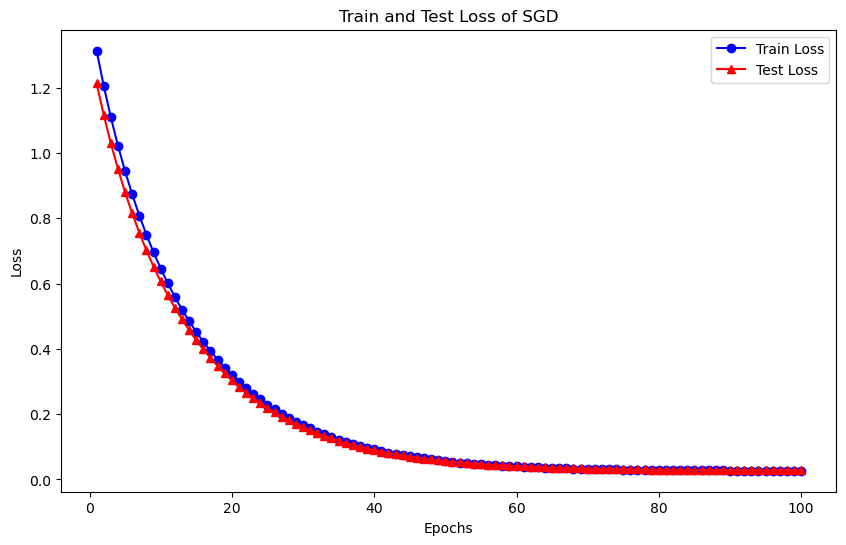

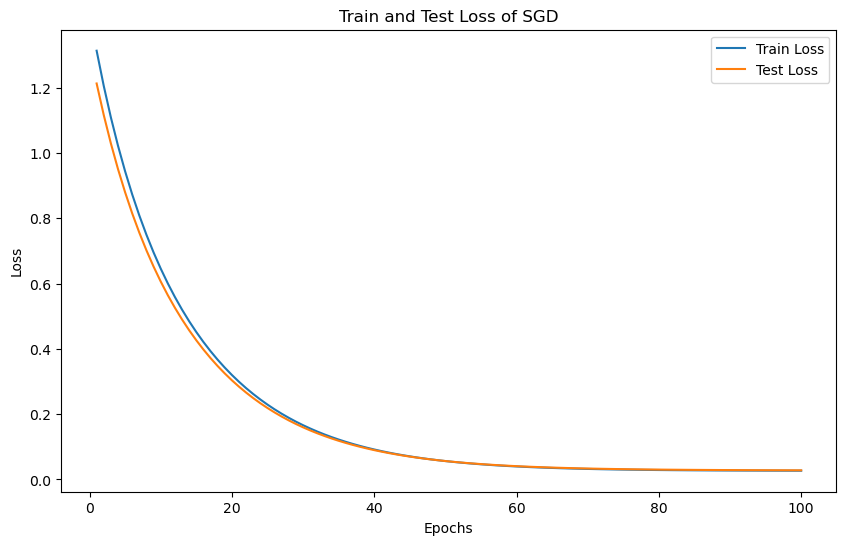

In [38]:
# your code here

epochs = range(1, num_epochs + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, "bo-", label="Train Loss")
plt.plot(epochs, test_loss, "r^-", label="Test Loss")
plt.title("Train and Test Loss of SGD")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

epochs = range(1, num_epochs + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, test_loss, label="Test Loss")
plt.title("Train and Test Loss of SGD")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

[0.82992959 0.78055441 0.73459721 0.69176525 0.65179753 0.61446166
 0.57954854 0.54687089 0.51625931 0.48756033 0.46063456 0.43535671
 0.4116118  0.38929498 0.36830962 0.34856763 0.32998842 0.31249738
 0.29602543 0.28050867 0.26588789 0.25210837 0.23911896 0.22687235
 0.21532452 0.20443413 0.19416267 0.18447419 0.17533492 0.16671328
 0.15857966 0.15090629 0.14366706 0.13683744 0.13039435 0.1243161
 0.11858217 0.11317337 0.10807143 0.1032593  0.09872077 0.09444062
 0.09040444 0.08659863 0.08301035 0.07962751 0.07643861 0.07343281
 0.0705999  0.06793021 0.06541461 0.06304443 0.0608115  0.05870813
 0.056727   0.05486122 0.05310426 0.05144995 0.04989248 0.04842633
 0.0470463  0.04574747 0.0445252  0.04337509 0.04229302 0.04127504
 0.04031747 0.03941682 0.03856978 0.03777326 0.03702431 0.03632016
 0.03565818 0.03503593 0.03445105 0.03390136 0.03338479 0.03289938
 0.0324433  0.0320148  0.03161226 0.03123413 0.03087895 0.03054536
 0.03023208 0.02993788 0.02966162 0.02940223 0.0291587  0.02893

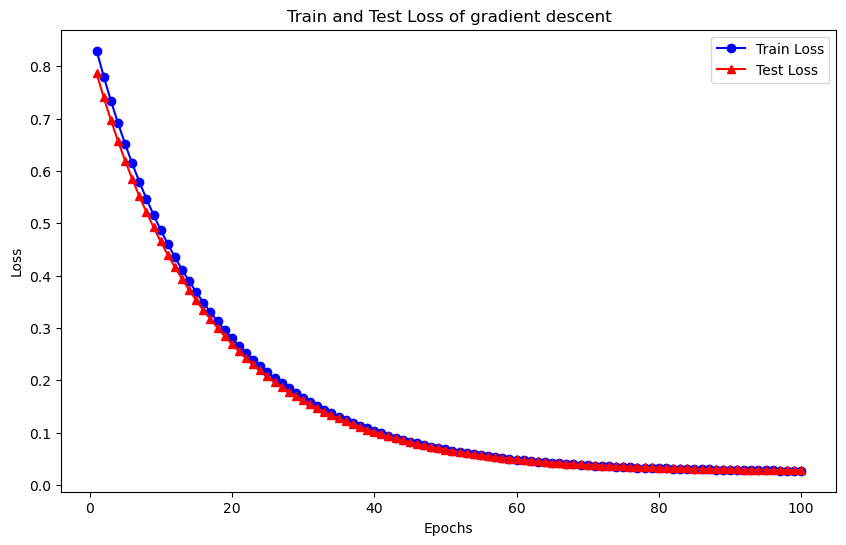

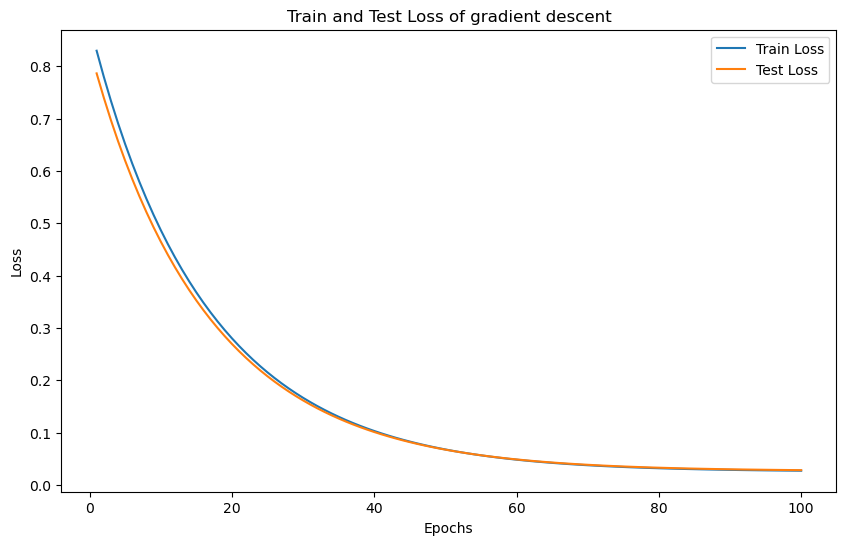

In [39]:
# 网络实例
net = Net(in_features_d, 5, 10, 3, out_features_d)

# 设置随机数种子
seed = 1
torch.manual_seed(seed)

# 损失函数
criterion = nn.MSELoss()

# 设置遍历数据集的次数
num_epochs = 100

# 设置学习率
learning_rate = 0.01

train_loss = np.zeros(num_epochs)  # 记录loss值的数组
test_loss = np.zeros(num_epochs)  # 记录loss值的数组

# 在每次循环中:
for i in range(num_epochs):
    # 训练部分
    net.train()  # 确保网络处于训练模式
    # 获取训练损失 并更新参数
    net.zero_grad()  # 梯度清零
    output_train = net(train_features)  # 前向传播
    loss0 = criterion(output_train, train_labels)  # 计算误差
    loss0.backward()  # 后向传播
    # 梯度下降法手动更新参数
    with torch.no_grad():
        for f in net.parameters():
            f.data.sub_(f.grad.data * learning_rate)
    train_loss[i] = loss0.item()  # 记录误差

    # 测试部分
    net.eval()  # 切换到评估模式
    # 获取测试损失
    with torch.no_grad():
        output_test = net(test_features)  # 前向传播
        loss1 = criterion(output_test, test_labels)  # 计算误差
        test_loss[i] = loss1.item()  # 记录误差

print(train_loss)
print(test_loss)
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, "bo-", label="Train Loss")
plt.plot(epochs, test_loss, "r^-", label="Test Loss")
plt.title("Train and Test Loss of gradient descent")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, test_loss, label="Test Loss")
plt.title("Train and Test Loss of gradient descent")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

[1.31332552 1.29920208 1.28517473 1.27124929 1.25742579 1.24371541
 1.23011196 1.21661246 1.2032212  1.18993688 1.17675948 1.16368842
 1.15072262 1.13786173 1.12511146 1.11246622 1.09992337 1.08748484
 1.07515144 1.06292188 1.05079067 1.03876078 1.02682889 1.01499605
 1.00326014 0.99162191 0.98008192 0.96863854 0.95728916 0.9460333
 0.93486917 0.9237954  0.9128105  0.90191311 0.89110041 0.88037091
 0.86972147 0.85914928 0.84865266 0.83822876 0.82787573 0.81758976
 0.80736685 0.79720402 0.78709781 0.77704442 0.76703972 0.75707835
 0.74715227 0.73726106 0.72739697 0.71755326 0.70772195 0.69790483
 0.68810135 0.67830771 0.66852307 0.65874332 0.64896446 0.63919193
 0.62942147 0.6196478  0.60986966 0.6000874  0.59029579 0.58048397
 0.57064217 0.56076562 0.55083907 0.54086083 0.53082597 0.52072549
 0.51055604 0.50031984 0.4900116  0.47963092 0.46918517 0.4586758
 0.44809932 0.43747064 0.42678815 0.41606072 0.40530121 0.39452723
 0.38374293 0.37295416 0.36216852 0.35139641 0.34065226 0.329943

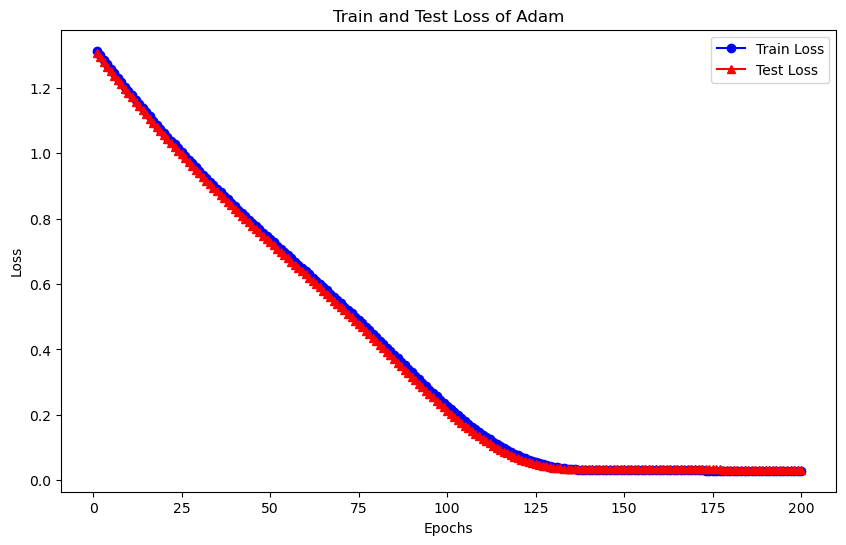

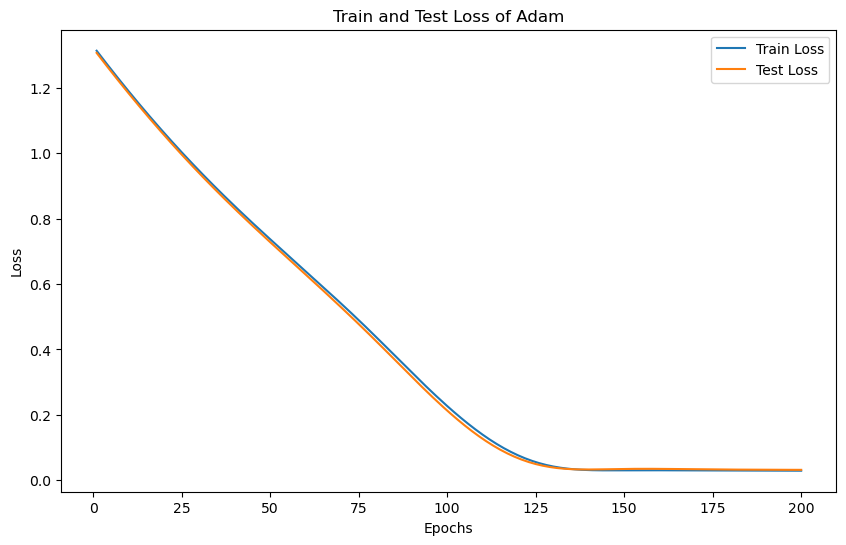

In [40]:
# your code here

# 用PyTorch的优化器来更新net中的参数
import torch.optim as optim

# 网络实例
net = Net(in_features_d, 5, 10, 3, out_features_d)

# 设置随机数种子
seed = 1
torch.manual_seed(seed)

# 损失函数
criterion = nn.MSELoss()

# 选择优化器
optimizer = optim.Adam(net.parameters(), lr=0.001)

# 获取训练样本
train_features = train[:, 0:in_features_d]  # 输入的训练集样本
train_labels = train[:, -1].reshape(-1, 1)  # 输入的训练集的label

# 获取测试样本
test_features = test[:, 0:in_features_d]  # 输入的训练集样本
test_labels = test[:, -1].reshape(-1, 1)  # 输入的训练集的label

# 设置遍历数据集的次数
num_epochs = 200

train_loss = np.zeros(num_epochs)  # 记录loss值的数组
test_loss = np.zeros(num_epochs)  # 记录loss值的数组

# 在每次循环中:
for i in range(num_epochs):
    # 训练部分
    net.train()  # 确保网络处于训练模式
    # 获取训练损失 并更新参数
    optimizer.zero_grad()  # 梯度清零
    output_train = net(train_features)  # 前向传播
    loss0 = criterion(output_train, train_labels)  # 计算误差
    loss0.backward()  # 后向传播
    optimizer.step()  # 参数更新
    train_loss[i] = loss0.item()  # 记录误差

    # 测试部分
    net.eval()  # 切换到评估模式
    # 获取测试损失
    with torch.no_grad():
        output_test = net(test_features)  # 前向传播
        loss1 = criterion(output_test, test_labels)  # 计算误差
        test_loss[i] = loss1.item()  # 记录误差

# 打印查看结果
print(train_loss)
print(test_loss)

epochs = range(1, num_epochs + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, "bo-", label="Train Loss")
plt.plot(epochs, test_loss, "r^-", label="Test Loss")
plt.title("Train and Test Loss of Adam")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

epochs = range(1, num_epochs + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, test_loss, label="Test Loss")
plt.title("Train and Test Loss of Adam")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

**<font color = blue size=4>第三部分:作业提交</font>**

一、实验课下课前提交完成代码，如果下课前未完成，请将已经完成的部分进行提交，未完成的部分于之后的实验报告中进行补充  
要求:  
1)文件格式为：学号-姓名.ipynb  
2)【不要】提交文件夹、压缩包、数据集等无关文件，只需提交单个ipynb文件即可

二、本次实验分为两周完成，实验报告提交截止日期: 12月15号14:20  
要求：  
1)文件格式为：学号-姓名.pdf  
2)【不要】提交文件夹、压缩包、代码文件、数据集等任何与实验报告无关的文件，只需要提交单个pdf文件即可  
3)文件命名时不需要额外添加“实验几”等额外信息，按照格式提交  

实验十二(神经网络)的实验报告上交地址: https://send2me.cn/Wk9FsyYO/SKCBsWeFtvwQsg

三、课堂课件获取地址:https://www.jianguoyun.com/p/DWHYtsEQp5WhChjwtKoFIAA
实验内容获取地址:https://www.jianguoyun.com/p/DbNY_SIQp5WhChjvtKoFIAA